# Legit or Misinformative?

The fundamental goal of this notebook is to build and compare different single and multi-level models to classify new text articles as Legit or Misinformative based on supervised learning from labelled datasets.  

The Results Summary is in [README.md](./README.md)

## Data Source Research Notes

### Kaggle
https://www.kaggle.com/datasets/vishakhdapat/fake-news-detection
https://www.kaggle.com/datasets/nitishjolly/news-detection-fake-or-real-dataset

These proved to be the cleanest and most comprehensive of the datasets I looked at.  They were used to build the models after investigating some other attempts (in Averitech.ipynb).

### Wikipedia

### Google Fact Check
https://toolbox.google.com/factcheck/apis

### FEVER
https://fever.ai/dataset/averitec.html
has training and test datasets

#### Averitech challenge
https://fever.ai/task.html

Github query: https://github.com/search?q=Fact+Extraction+and+VERification+%28FEVER%29&type=repositories&s=updated&o=desc

Hugging Face repo: https://huggingface.co/chenxwh/AVeriTeC

### Search for NLP veracity checking
https://github.com/kianfattahy/Text-Veracity-Classification

https://www.mdpi.com/2411-9660/5/3/42

opinion phrases: https://vladsandulescu.com/opinion-phrases/?utm_content=buffer56740&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer


## Library Imports

In [1]:
# import the necessary libraries
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import nltk
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# import the shared custom transformer which is used here and by the Legitimizer app
import importlib
import shared_components.custom_transformers  # Import the whole module first
importlib.reload(shared_components.custom_transformers)  # Reload it to reflect changes
from shared_components.custom_transformers import LemmatizerStemmer  # Import the specific function/class


# Classifier Training

## Kaggle Datasets
1. Base set: https://www.kaggle.com/datasets/vishakhdapat/fake-news-detection <br>
2. Large set:https://www.kaggle.com/datasets/sadmansakibmahi/fake-news-detection-dataset-with-pre-trained-model

We compared the outcome of parameter grid searches for both datasets between Logistic Regression, Decision Tree and MultinomialNB.

In addition to using 5 fold cross-validation, we experimented with different sample sizes.

We also cross tested - comparing Test Set Score to Cross Test Score for a sample from the other database.



In [2]:
#import the datasets
df_Base = pd.read_csv('data/fake_and_real_news.csv')
df_FakeNews = pd.read_csv('data/Training.csv')

In [3]:
# setup a dataframe to store the results of the different model searches
results_df = pd.DataFrame({'model': ['Logistic', 'Decision Tree', 'Bayes'], 
             'best_params': ['', '', ''],
             'best_score': ['', '', ''], 
             'fit_time': ['', '', ''],
             'best_estimator': ['', '', '']}).set_index('model')

In [4]:
# Ensure nltk resources are downloaded
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johnraegrant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnraegrant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Stemming and Lemmatizing

The datasets were both stemmed and lemmatized as preprocessing before training the classifiers.

LemmatizerStemmer has been moved to a separate Python file for use by both this notebook and the Legitimizer Streamlit app.

In [5]:
# Custom transformer for lemmatization
class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join([self.lemmatizer.lemmatize(word) for word in text.split()]) for text in X]

In [6]:
# Custom transformer for stemming
class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = PorterStemmer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join([self.stemmer.stem(word) for word in text.split()]) for text in X]

## Pipeline and Parameters Setup

In [7]:
# Pipeline setup
pipeline = Pipeline([
    ('preprocess', LemmatizerStemmer()), 
    ('vectorize', CountVectorizer()),  # Placeholder; will be set to CountVectorizer or TfidfVectorizer in the param grid
    ('classifier', LogisticRegression())  # Placeholder; will be set to specific classifiers in the param grid
])

# classifier parameters for each classifier
classifier_params = {
    'Logistic': {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__max_iter': [10000],
        'classifier__solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [20],
        'classifier__min_samples_split': [5, 10],
        'classifier__min_samples_leaf': [5],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__criterion': ['gini', 'entropy']
    },
    'Bayes': {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.1, 1.0, 10.0],
        'classifier__fit_prior': [False],
        'classifier__class_prior': [None]
    }
}

In [8]:

# Parameter grid for grid search
param_grid = {
    'vectorize': [TfidfVectorizer(stop_words=stopwords.words('english')), CountVectorizer(stop_words=stopwords.words('english'))],  # Switch between CountVectorizer and TfidfVectorizer
    'vectorize__max_features': [500]
}

## Dataset Switching

In [9]:
def set_dataset(df, sample, name):
    # Set up X and Y and the sample df from the given dataset
    print(f'{name}: size of dataset: {len(df)}')
    sample_df = df.sample(frac=sample, random_state=42)
    print(f'{name}: size of sample dataset: {len(sample_df)}')
    
    # set the X and y
    X = sample_df['Text']
    y = sample_df['label']

    # show the value counts for the target
    print(y.value_counts())

    return X, y

## Parameter printing and parsing

In [10]:
import ast

import re

def extract_parameters(input_string):
    # Regular expression to find content within the first pair of parentheses
    match = re.search(r'\(([^()]*)\)', input_string)
    if match:
        return match.group(1)  # Returns the content inside the parentheses
    return None  # Returns None if no parentheses found

In [11]:
def print_params(param_str):
    # Regular expression to match key-value pairs in the form: 'key': value
    param_pattern = re.compile(r"'([^']+)':\s*([^,]+)")
    # Find all matches for key-value pairs in the string
    matches = param_pattern.findall(param_str)

    # Print each parameter and its value
    for key, value in matches:
        if '__' in key:
            key, param = key.split('__')
            print(f"\t\t{param} = {value}")     
        else :
            print(f"\t{key}: {value}")


In [12]:
def parse_params(param_str):
    # Regular expression to match key-value pairs in the form: 'key': value
    param_pattern = re.compile(r"'([^']+)':\s*([^,]+)")

    # Find all matches for key-value pairs in the string
    matches = param_pattern.findall(param_str)

    parm_out = {}
    
    # Store each parameter and its value in the results 
    for key, value in matches:
        if '__' in key:
            key, param = key.split('__')
            parm_out[param] = value
            print(f"\t\t{param} = {value}")
        else:
            parm_out[key] = value
            print(f"\t{key}: {value}")

    return parm_out

## Single Layer Grid Search

In [13]:
def run_grids(pipeline, param_grid, classifier_params, X_train, y_train):
    # Run grid searches for each type of model and return the results in a dataframe
    results_df = pd.DataFrame({'model': list(classifier_params.keys()), 
             'best_params': [''] * len(classifier_params), 
             'best_score': [''] * len(classifier_params), 
             'fit_time': [''] * len(classifier_params), 
             'best_estimator': [''] * len(classifier_params)}).set_index('model')

    # do a grid search for each model
    for model in classifier_params.keys():
        print(f'Running grid search for {model}')
        gs = GridSearchCV(pipeline, param_grid={**param_grid, **classifier_params[model]}, cv=5, verbose=1,n_jobs=-1)
        gs.fit(X_train, y_train)
        results_df.loc[model, 'best_params'] = str(gs.best_params_)
        results_df.loc[model, 'best_score'] = gs.best_score_
        results_df.loc[model, 'fit_time'] = gs.cv_results_['mean_fit_time'][gs.best_index_]
        results_df.loc[model, 'best_estimator'] = gs.best_estimator_

    return results_df



### Grid Search on Base Dataset

In [14]:
# Run Grid Searches for the Base dataset

X, y = set_dataset(df_Base, 0.25, 'Base')

# test train split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

resultsBase_df = run_grids(pipeline, param_grid, classifier_params, X_train, y_train)

# save the results to a file
resultsBase_df.to_csv(f'results/Base_{len(X)}results.csv')

Base: size of dataset: 9900
Base: size of sample dataset: 2475
label
Real    1265
Fake    1210
Name: count, dtype: int64
Running grid search for Logistic
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Running grid search for Decision Tree
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Running grid search for Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits


### Results for the Base Dataset

In [16]:
resultsBase_df

,best_params,best_score,fit_time,best_estimator
model,,,,
Logistic,"{'classifier': LogisticRegression(), 'classifi...",0.99798,15.976978,"(LemmatizerStemmer(), TfidfVectorizer(max_feat..."
Decision Tree,"{'classifier': DecisionTreeClassifier(), 'clas...",0.966667,14.958722,"(LemmatizerStemmer(), CountVectorizer(max_feat..."
Bayes,"{'classifier': MultinomialNB(), 'classifier__a...",0.975253,16.198738,"(LemmatizerStemmer(), CountVectorizer(max_feat..."


### Grid Search on the FakeNews Dataset

In [17]:
#run for the FakeNews dataset

X, y = set_dataset(df_FakeNews, 0.025, 'FakeNews')

# test train split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

resultsFakeNews_df = run_grids(pipeline, param_grid, classifier_params, X_train, y_train)

# save the results to a file
resultsFakeNews_df.to_csv(f'results/FakeNews_{len(X)}results.csv')


FakeNews: size of dataset: 83539
FakeNews: size of sample dataset: 2088
label
Real    1052
Fake    1036
Name: count, dtype: int64
Running grid search for Logistic
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Running grid search for Decision Tree
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Running grid search for Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits


### Results for the Large Dataset

In [18]:
resultsFakeNews_df

,best_params,best_score,fit_time,best_estimator
model,,,,
Logistic,"{'classifier': LogisticRegression(), 'classifi...",0.993413,12.755276,"(LemmatizerStemmer(), TfidfVectorizer(max_feat..."
Decision Tree,"{'classifier': DecisionTreeClassifier(), 'clas...",0.930539,12.291208,"(LemmatizerStemmer(), CountVectorizer(max_feat..."
Bayes,"{'classifier': MultinomialNB(), 'classifier__a...",0.948503,12.810765,"(LemmatizerStemmer(), CountVectorizer(max_feat..."


### Best Parameters from Grid Search

In [19]:
# pretty print the results

for model in resultsFakeNews_df.index:
    print(f"Results for FakeNews {model}")
    print(f"\tBest score: {resultsFakeNews_df.loc[model, 'best_score']}")
    print(f"\tFit time: {resultsFakeNews_df.loc[model, 'fit_time']}")
    print_params(resultsFakeNews_df.loc[model, 'best_params'])
    print('\n')

for model in resultsBase_df.index:
    print(f"Results for Base {model}")
    print(f"\tBest score: {resultsBase_df.loc[model, 'best_score']}")
    print(f"\tFit time: {resultsBase_df.loc[model, 'fit_time']}")
    print_params(resultsBase_df.loc[model, 'best_params'])
    print('\n')


Results for FakeNews Logistic
	Best score: 0.9934131736526947
	Fit time: 12.755275964736938
	classifier: LogisticRegression()
		C = 10.0
		max_iter = 10000
		penalty = 'l1'
		solver = 'liblinear'
	vectorize: TfidfVectorizer(stop_words=['i'
		max_features = 500}


Results for FakeNews Decision Tree
	Best score: 0.9305389221556887
	Fit time: 12.291208267211914
	classifier: DecisionTreeClassifier()
		criterion = 'entropy'
		max_depth = 20
		max_features = 'sqrt'
		min_samples_leaf = 5
		min_samples_split = 5
	vectorize: CountVectorizer(stop_words=['i'
		max_features = 500}


Results for FakeNews Bayes
	Best score: 0.948502994011976
	Fit time: 12.810765409469605
	classifier: MultinomialNB()
		alpha = 0.1
		class_prior = None
		fit_prior = False
	vectorize: CountVectorizer(stop_words=['i'
		max_features = 500}


Results for Base Logistic
	Best score: 0.9979797979797981
	Fit time: 15.976977872848511
	classifier: LogisticRegression()
		C = 10.0
		max_iter = 10000
		penalty = 'l1'
		solver = '

## Confusion Matrix for best model

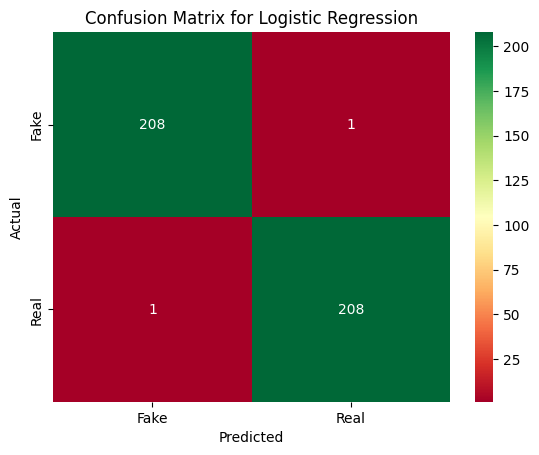

In [21]:
# give a nice plot of the confusion matrix for logistic regression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = resultsFakeNews_df.loc['Logistic', 'best_estimator'].predict(X_val)
cm = confusion_matrix(y_val, y_pred)
# use a light red to dark green color map
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn')
# replace the labels with more meaningful names
plt.xticks([0.5, 1.5], ['Fake', 'Real'])
plt.yticks([0.5, 1.5], ['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

## Comparing Results
Now we retrieve the results from different runs with different sample sizes and datasets in order to compare the effectiveness and scaling of the models.

In [22]:
# read in all of the results from the files in data/{size}results.csv
import os

uber_df = pd.DataFrame()
for file in os.listdir('results'):
    if 'results' in file:
        print(f'loading {file}')
        #parse out the size and setname from the filename which is in form {setname}_{size}results.csv
        setname = file.split('_')[0]
        size = int(file.split('_')[1].split('results')[0])

        df = pd.read_csv(f'results/{file}')
        df['size'] = size
        df['dataset'] = setname
        uber_df = pd.concat([uber_df, df])

uber_df


loading Base_4950results.csv
loading Base_2475results.csv
loading FakeNews_2088results.csv
loading Base_9900results.csv
loading Base_1980results.csv
loading FakeNews_4177results.csv
loading FakeNews_8354results.csv


,model,best_score,fit_time,best_params,best_estimator,size,dataset
0,Logistic,0.998990,10.535047,"{'classifier': LogisticRegression(C=10.0, max_...","Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base
1,Decision Tree,0.981566,9.747898,{'classifier': DecisionTreeClassifier(max_dept...,"Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base
2,Bayes,0.975505,9.496118,"{'classifier': MultinomialNB(alpha=0.1, fit_pr...","Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base
0,Logistic,0.997980,15.976978,"{'classifier': LogisticRegression(), 'classifi...","Pipeline(steps=[('preprocess', LemmatizerStemm...",2475,Base
1,Decision Tree,0.966667,14.958722,"{'classifier': DecisionTreeClassifier(), 'clas...","Pipeline(steps=[('preprocess', LemmatizerStemm...",2475,Base
2,Bayes,0.975253,16.198738,"{'classifier': MultinomialNB(), 'classifier__a...","Pipeline(steps=[('preprocess', LemmatizerStemm...",2475,Base
0,Logistic,0.993413,12.755276,"{'classifier': LogisticRegression(), 'classifi...","Pipeline(steps=[('preprocess', LemmatizerStemm...",2088,FakeNews
1,Decision Tree,0.930539,12.291208,"{'classifier': DecisionTreeClassifier(), 'clas...","Pipeline(steps=[('preprocess', LemmatizerStemm...",2088,FakeNews
2,Bayes,0.948503,12.810765,"{'classifier': MultinomialNB(), 'classifier__a...","Pipeline(steps=[('preprocess', LemmatizerStemm...",2088,FakeNews
0,Logistic,0.998737,20.922753,"{'classifier': LogisticRegression(C=10.0, max_...","Pipeline(steps=[('preprocess', LemmatizerStemm...",9900,Base


In [23]:
# sort the uber_df by model and size
uber_df.sort_values(by=['size'], inplace=True)

print_df = uber_df[['model','size', 'dataset', 'best_score', 'fit_time']]
# sort by model and size
print_df.sort_values(by=['model', 'size'], inplace=True)
#reindex by model
print_df.set_index('model', inplace=True)

print_df

/var/folders/v0/7hny_wjs4tg70rryd7blqpd00000gn/T/ipykernel_45085/773386601.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print_df.sort_values(by=['model', 'size'], inplace=True)


,size,dataset,best_score,fit_time
model,,,,
Bayes,1980,Base,0.973482,12.097990
Bayes,2088,FakeNews,0.948503,12.810765
Bayes,2475,Base,0.975253,16.198738
Bayes,4177,FakeNews,0.958696,7.474342
Bayes,4950,Base,0.975505,9.496118
Bayes,8354,FakeNews,0.957055,15.505293
Bayes,9900,Base,0.973737,20.876189
Decision Tree,1980,Base,0.952608,15.018304
Decision Tree,2088,FakeNews,0.930539,12.291208


### Winning model of each type

In [24]:
# make best_results dataframe from the uber_df sorted by Model and RMSE
best_results = uber_df.sort_values(by=['model', 'best_score']).groupby('model').last().reset_index()

#sort the best_results by best score from highest to lowest
best_results = best_results.sort_values(by='best_score', ascending=False)

# reindex the best_results dataframe using 'Model'
best_results = best_results.set_index('model')

best_results

,best_score,fit_time,best_params,best_estimator,size,dataset
model,,,,,,
Logistic,0.998990,10.535047,"{'classifier': LogisticRegression(C=10.0, max_...","Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base
Decision Tree,0.981566,9.747898,{'classifier': DecisionTreeClassifier(max_dept...,"Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base
Bayes,0.975505,9.496118,"{'classifier': MultinomialNB(alpha=0.1, fit_pr...","Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base


### Show the Coefficients

In [25]:
# show the coefs for the best model
coefs = resultsBase_df.loc['Logistic', 'best_estimator'].named_steps['classifier'].coef_[0]

# get the feature names
feature_names = resultsBase_df.loc['Logistic', 'best_estimator'].named_steps['vectorize'].get_feature_names_out()

# create a dataframe of the feature names and the coefs
coefs_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})

# sort the dataframe by the absolute value of the coef
coefs_df['abs_coef'] = coefs_df['coef'].abs()
coefs_df = coefs_df.sort_values(by='abs_coef', ascending=False)


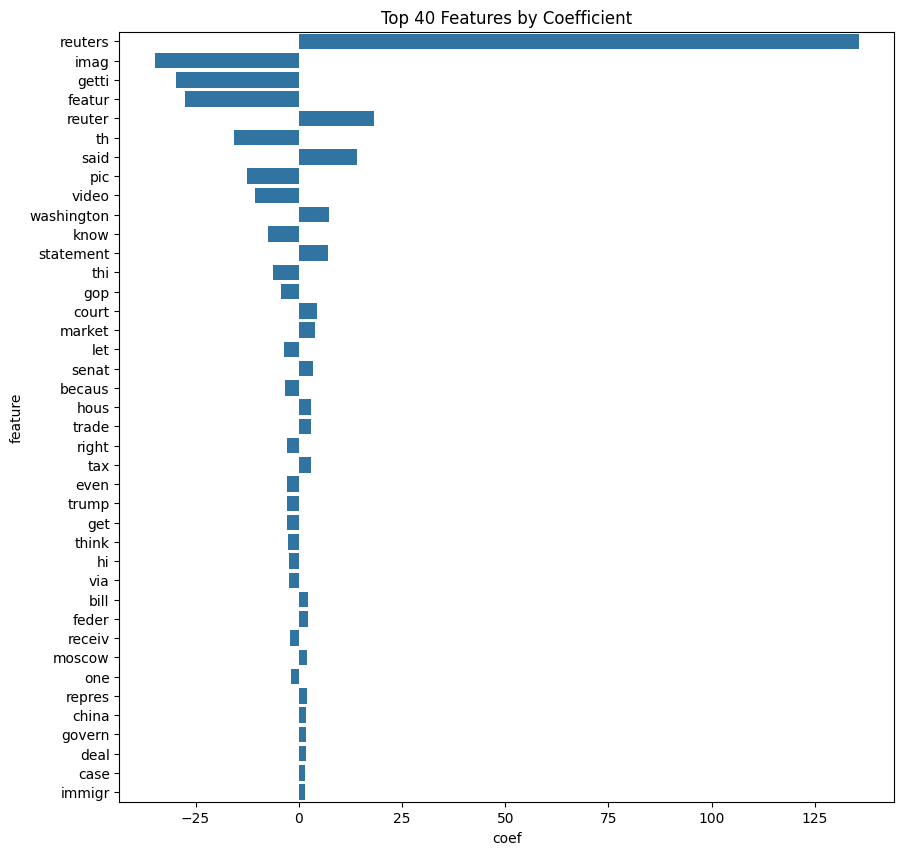

In [26]:
# plot the top 40 features by absolute value of the coef
plt.figure(figsize=(10, 10))
sns.barplot(x='coef', y='feature', data=coefs_df.iloc[:40])
plt.title('Top 40 Features by Coefficient')
plt.show()


### Plots to compare sample size on score and training time

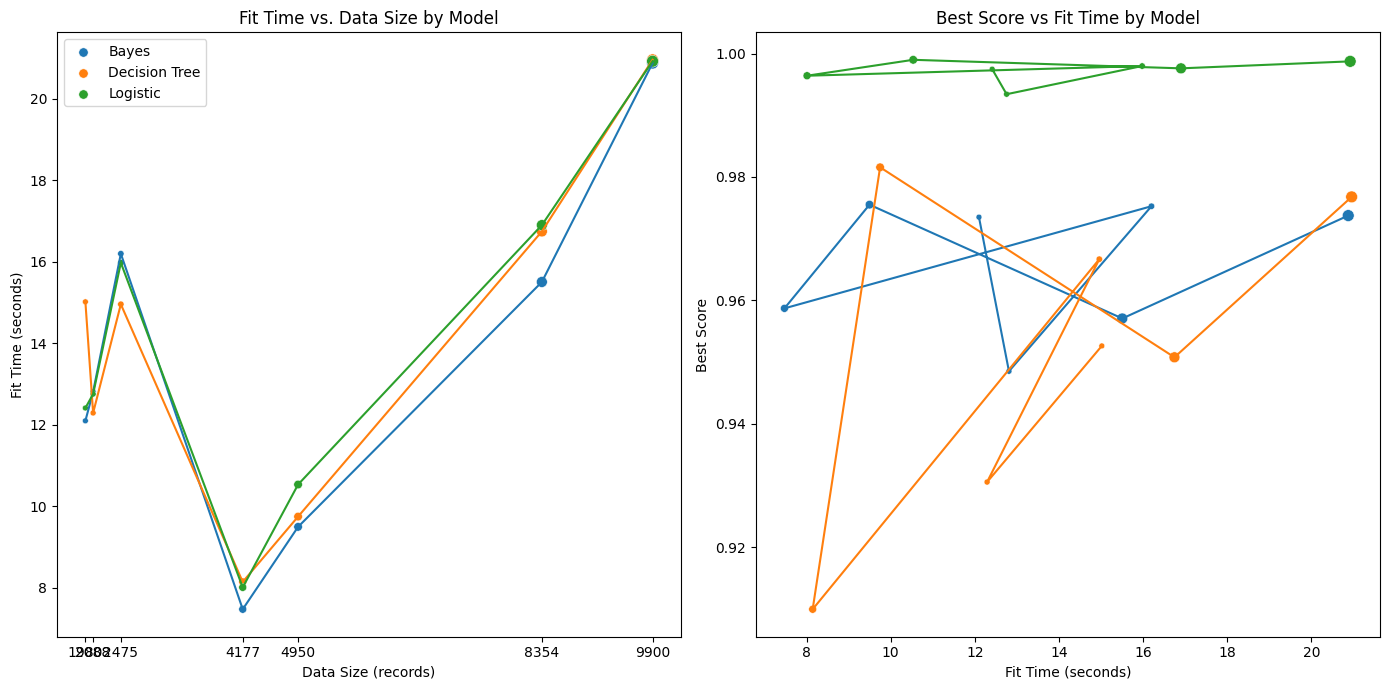

In [27]:

df = uber_df

#Normalize the size for the scatter plot
size_scale = lambda x: (x - df['size'].min()) / (df['size'].max() - df['size'].min())
df['Size'] = df['size'].map(size_scale)

# Choose a palette
pal = sns.color_palette('tab10', n_colors=df['model'].nunique())

# Creating scatter and line plots
plt.figure(figsize=(14, 7))

# Plotting Training Time vs RMSE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
for i, (name, group) in enumerate(df.groupby('model')):
    group = group.sort_values('size')
    sns.scatterplot(data=group, x='size', y='fit_time', size='Size', color=pal[i], label=name, legend=None)
    sns.lineplot(data=group, x='size', y='fit_time', color=pal[i])

plt.title('Fit Time vs. Data Size by Model')
plt.ylabel('Fit Time (seconds)')
plt.xlabel('Data Size (records)')

#only show x ticks for the actual sizes
plt.xticks(df['size'].unique())

plt.legend()

# Plotting Training Time vs MAE
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
for i, (name, group) in enumerate(df.groupby('model')):
    group = group.sort_values('Size')
    sns.scatterplot(data=group, x='fit_time', y='best_score', size='Size', color=pal[i], label=name, legend=None)
    plt.plot(group['fit_time'], group['best_score'], color=pal[i])

plt.title('Best Score vs Fit Time by Model')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Fit Time (seconds)')
plt.ylabel('Best Score')

plt.tight_layout()
plt.show()

### Decision Tree Visualization

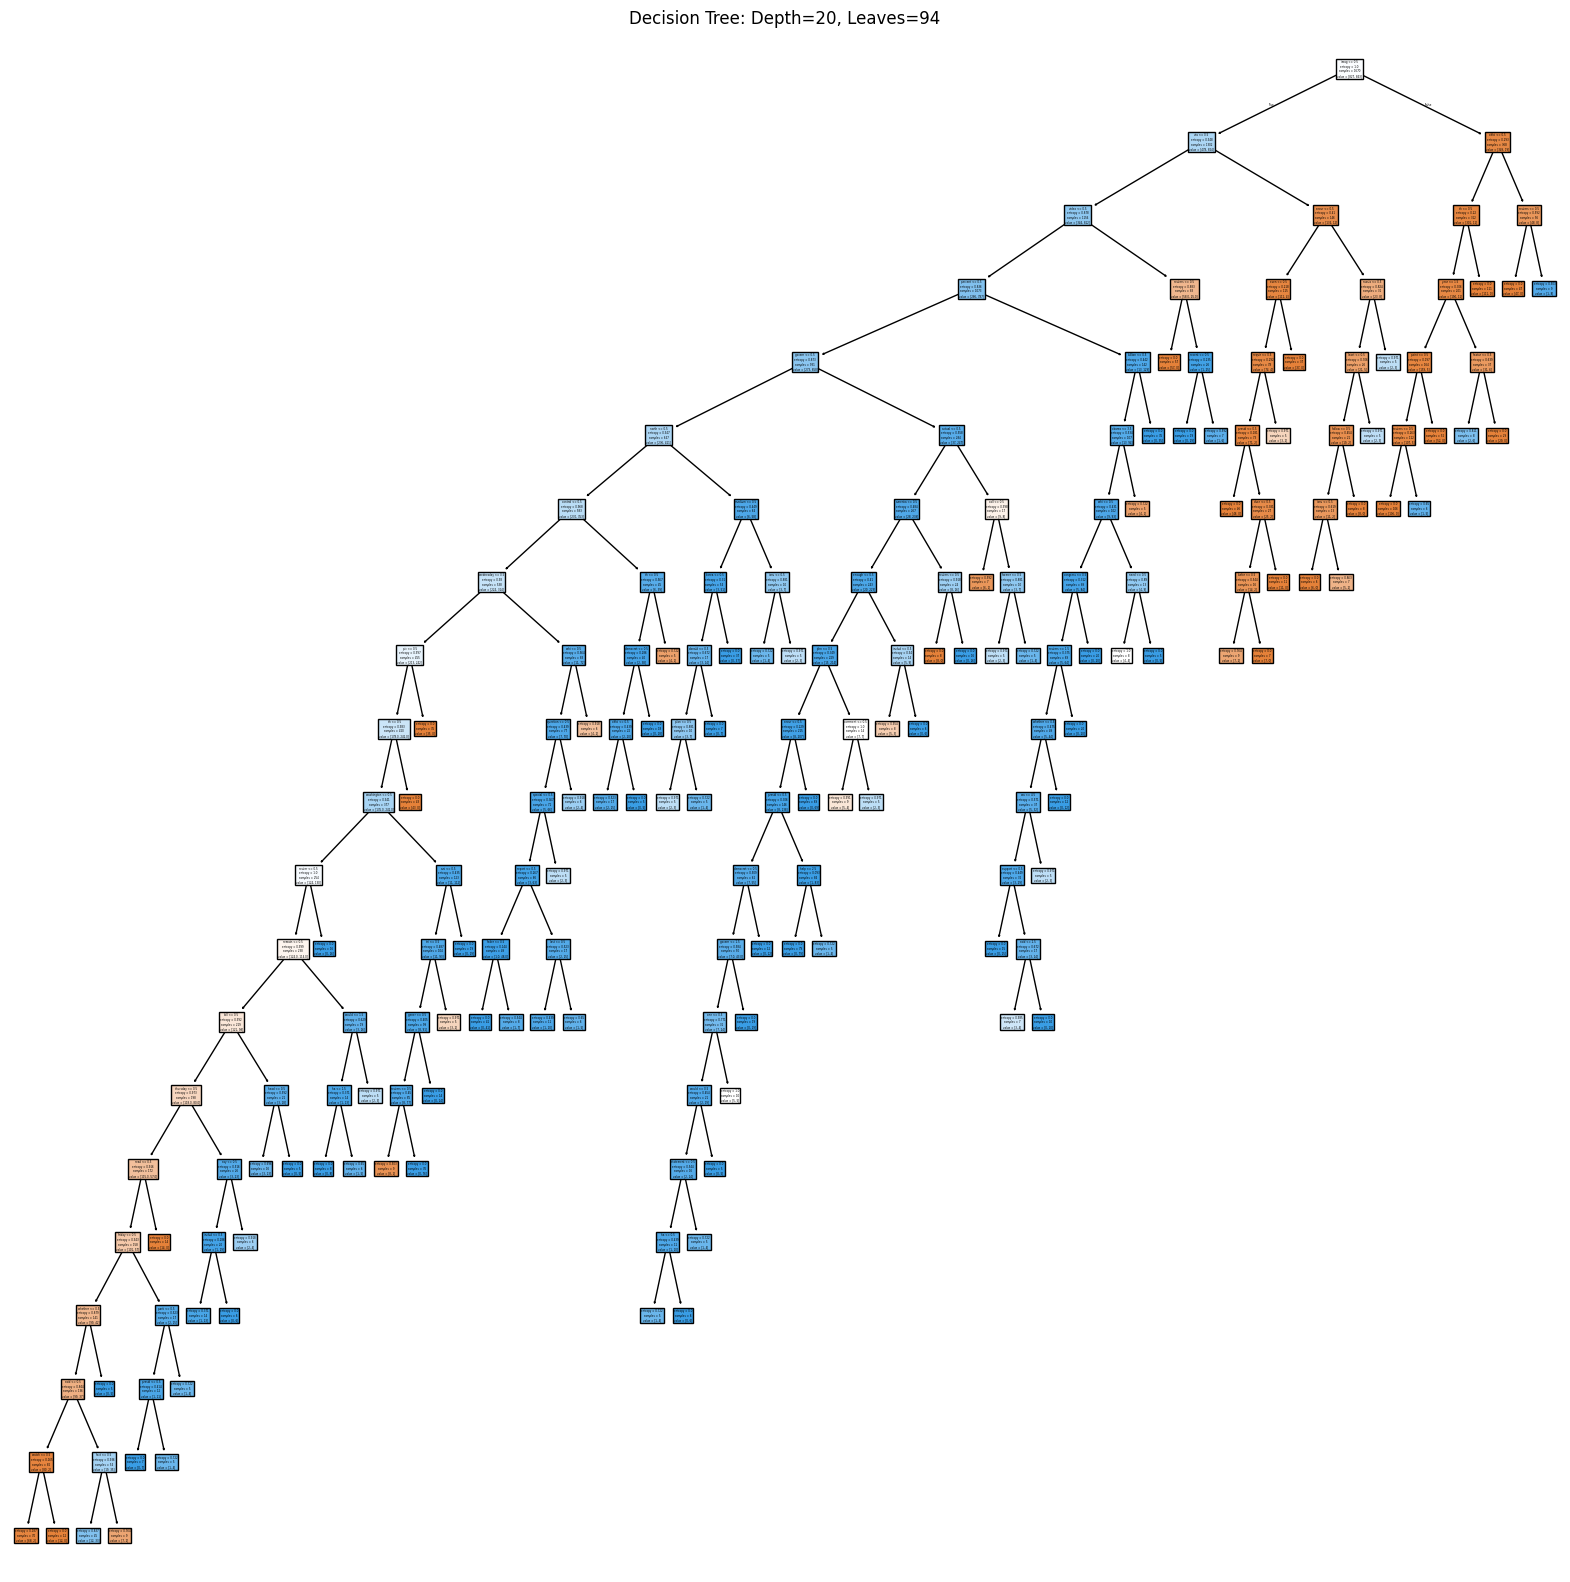

In [28]:
# show the decision tree
from sklearn.tree import plot_tree

# get the best decision tree
dt = resultsFakeNews_df.loc['Decision Tree', 'best_estimator']

# plot the tree
plt.figure(figsize=(20, 20))
plot_tree(dt.named_steps['classifier'], feature_names=dt.named_steps['vectorize'].get_feature_names_out(), filled=True)
# add a title
plt.title(f'Decision Tree: Depth={dt.named_steps["classifier"].get_depth()}, Leaves={dt.named_steps["classifier"].get_n_leaves()}')
plt.show()

### Cross Test to choose the winning model
Test each model with a random sample from the other dataset.

In [34]:
# test each FakeNews model against a test sample from df_Base
sample2_df = df_Base.sample(frac=0.5)
X_val = sample2_df['Text']
y_val = sample2_df['label']

df_crosstestFake = pd.DataFrame(columns=['model', 'Training Score', 'Cross Test Score']).set_index('model')

# run the test
for model in resultsFakeNews_df.index:
    print(f"Testing FakeNews {model}")
    df_crosstestFake.loc[model, 'Training Score'] = resultsFakeNews_df.loc[model, 'best_score']
    y_pred = resultsFakeNews_df.loc[model, 'best_estimator'].predict(X_val)
    df_crosstestFake.loc[model, 'Cross Test Score'] = sum(y_pred == y_val) / len(y_val)



Testing FakeNews Logistic
Testing FakeNews Decision Tree
Testing FakeNews Bayes


In [35]:
# show the cross training results for trained with FakeNews and tested with Base
df_crosstestFake

,Training Score,Cross Test Score
model,,
Logistic,0.993413,0.991515
Decision Tree,0.930539,0.946667
Bayes,0.948503,0.974949


In [36]:
# test each Base model against a test sample from df_FakeNews
sample3_df = df_FakeNews.sample(frac=0.05)
X_val = sample3_df['Text']
y_val = sample3_df['label']

df_crosstestBase = pd.DataFrame(columns=['model', 'Training Score', 'Cross Test Score']).set_index('model')

# run the test
for model in resultsBase_df.index:
    print(f"Testing {model}")
    df_crosstestBase.loc[model, 'Training Score'] = resultsBase_df.loc[model, 'best_score']
    y_pred = resultsBase_df.loc[model, 'best_estimator'].predict(X_val)
    df_crosstestBase.loc[model, 'Cross Test Score'] = sum(y_pred == y_val) / len(y_val)

Testing Logistic
Testing Decision Tree
Testing Bayes


In [37]:
df_crosstestBase

,Training Score,Cross Test Score
model,,
Logistic,0.99798,0.980608
Decision Tree,0.966667,0.823797
Bayes,0.975253,0.934642


### Final Single Layer Model Choice!

And the winner is ... the LogisticRegression model trained on the Large dataset.

Logistic Regression
Trained on Large model sample of 8354 records
Stemmed and Lemmatized (stop_words=stopwords.words('english'))
TfidfVectorizer(max_features=500)
C = 10.0
max_iter = 10000
penalty = 'l1'
solver = 'liblinear'

Training Accuracy: 99.34%
Cross Test:        99.15%

## Pickle the final model for deployment and access through the API



In [26]:
# rerun the model with the best parameters
pipeline = Pipeline([
    ('preprocess', LemmatizerStemmer()), 
    ('vectorize', TfidfVectorizer(stop_words=stopwords.words('english'), max_features=500)),  
    ('classifier', LogisticRegression())  # Placeholder; will be set to specific classifiers in the param grid
])

# classifier parameters for each classifier
classifier_params = {
    'Logistic': {
        'classifier': [LogisticRegression()],
        'classifier__C': [10.0],
        'classifier__penalty': ['l1'],
        'classifier__max_iter': [10000],
        'classifier__solver': ['liblinear']
    }
}

# Parameter grid for grid search
param_grid = {
    'vectorize': [TfidfVectorizer(stop_words=stopwords.words('english'), max_features=500)]
}



In [25]:
import sys
if 'custom_transformers' in sys.modules:
    del sys.modules['custom_transformers']
import custom_transformers
from custom_transformers import LemmatizerStemmer

In [27]:

# run the model
X, y = set_dataset(df_FakeNews, 0.1, 'FakeNews')

# test train split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

resultsFakeNews_df = run_grids(pipeline, param_grid, classifier_params, X_train, y_train)


FakeNews: size of dataset: 83539
FakeNews: size of sample dataset: 8354
label
Real    4232
Fake    4122
Name: count, dtype: int64
Running grid search for Logistic
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [28]:
# set legitimizer to the best model
legitimizer = resultsFakeNews_df.loc['Logistic', 'best_estimator']
legitimizer

Pipeline(steps=[('preprocess', LemmatizerStemmer()),
                ('vectorize',
                 TfidfVectorizer(max_features=500,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('classifier',
                 LogisticRegression(C=10.0, max_iter=10000, penalty='l1',
                                    solver='liblinear'))])

In [29]:
import joblib

#save the winning single layer model for use by the Legitimizer app
joblib.dump(legitimizer, "legitimizer.pkl")

['legitimizer.pkl']

In [9]:
import joblib

# reload the model
legitimizer2 = joblib.load("legitimizer.pkl")

### Choose example articles to populate and test the app

As an added feature of the Legitimizer app, we give the user the ability to choose "Next Article" from a 100 article sample from the FakeNews dataset.

In [33]:
X, y = set_dataset(df_FakeNews, 0.025, 'FakeNews')

#train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# run the model over X_test
y_pred = legitimizer2.predict(X_val)

# create a dataframe with the results
sample3_df = pd.DataFrame(X_val)

# add the confidence level to the dataframe
sample3_df['legitimizer'] = y_pred
sample3_df['confidence'] = legitimizer2.predict_proba(X_val)[:, 1]


FakeNews: size of dataset: 83539
FakeNews: size of sample dataset: 2088
label
Real    1052
Fake    1036
Name: count, dtype: int64


In [35]:
# choose 50 articles that are classified as fake
df_Chosen = sample3_df[sample3_df['legitimizer'] == 'Fake'].sort_values(by='confidence', ascending=False).head(50)

# add 50 articles that are classified as real
df_Chosen = pd.concat([df_Chosen, sample3_df[sample3_df['legitimizer'] == 'Real'].sort_values(by='confidence', ascending=False).head(50)])

# randomly shuffle the dataframe
df_Chosen = df_Chosen.sample(frac=1)
df_Chosen.to_csv('data/Chosen.csv', index=False)


# Using Multi-Level Neural Networks

Having found the best classifier based on a single layer model, let's try improving this using an MNN.

## Choose the training dataset for MNNs

We will use the FakeNews dataset to train and compare different MNNs.

In [108]:
X, y = set_dataset(df_FakeNews, 0.1, 'FakeNews')

# make the y a binary value
y = y.apply(lambda x: 1 if x == 'Real' else 0)

#train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

FakeNews: size of dataset: 83539
FakeNews: size of sample dataset: 8354
label
Real    4232
Fake    4122
Name: count, dtype: int64


## Set up the tokenizer

Preprocessing is slightly different for the MNNs, as they treat the article text as a series of sequences of words.

In [109]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 20000  # Vocabulary size
max_seq_len = 300  # Length of sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)  # `texts` is the dataset of articles
X_token = tokenizer.texts_to_sequences(X)
X_token = pad_sequences(X_token, maxlen=max_seq_len)

In [ ]:
# Save the tokenizer for inclusion in the Legitimizer web app
# similar to how we saved the models, we need to separately save 
# the fitted tokenizer for use in the Legitimizer app.
import joblib
joblib.dump(tokenizer, 'saved_models/tokenizer.pkl')


NameError: name 'tokenizer' is not defined

## Train Test Sample Split

In [111]:
X_train, X_val, y_train, y_val = train_test_split(X_token, y, test_size=0.2, random_state=42)


## Define and compile each of the different MNN's

We compare performance of LSTM, GRU and Conv1D MNNs.

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/Users/johnraegrant/Haas AI Certificate/Module 20/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

gru_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_len),
    GRU(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

conv1d_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_len),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

conv1d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/Users/johnraegrant/Haas AI Certificate/Module 20/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Fit the MNN's

In [115]:
history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)
history_gru = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)
history_conv1d = conv1d_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 326ms/step - accuracy: 0.8483 - loss: 0.4079 - val_accuracy: 0.9665 - val_loss: 0.1060
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 347ms/step - accuracy: 0.9857 - loss: 0.0458 - val_accuracy: 0.9455 - val_loss: 0.1382
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 338ms/step - accuracy: 0.9847 - loss: 0.0561 - val_accuracy: 0.9617 - val_loss: 0.1023
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 347ms/step - accuracy: 0.9965 - loss: 0.0165 - val_accuracy: 0.9731 - val_loss: 0.0917
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 340ms/step - accuracy: 0.9991 - loss: 0.0056 - val_accuracy: 0.9719 - val_loss: 0.1208
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 337ms/step - accuracy: 0.9996 - loss: 0.0028 - val_accuracy: 0.9695 - val_loss: 0.1140
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 330ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9611 - val_loss: 0.1419
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 331ms/step - accuracy: 0.9980 - loss: 0

## Compare the models' performance and evolution

In [116]:
from sklearn.metrics import classification_report, roc_auc_score

# Evaluate LSTM
y_pred_lstm = (lstm_model.predict(X_val) > 0.5).astype("int32")
print("LSTM Classification Report")
print(classification_report(y_val, y_pred_lstm))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_lstm))

# Evaluate GRU
y_pred_gru = (gru_model.predict(X_val) > 0.5).astype("int32")
print("GRU Classification Report")
print(classification_report(y_val, y_pred_gru))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_gru))

# Evaluate Conv1D
y_pred_conv1d = (conv1d_model.predict(X_val) > 0.5).astype("int32")
print("Conv1D Classification Report")
print(classification_report(y_val, y_pred_conv1d))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_conv1d))



53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step
LSTM Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       804
           1       0.94      0.98      0.96       867

    accuracy                           0.96      1671
   macro avg       0.96      0.96      0.96      1671
weighted avg       0.96      0.96      0.96      1671

ROC-AUC: 0.9590111725111466
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
GRU Classification Report
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       804
           1       0.00      0.00      0.00       867

    accuracy                           0.48      1671
   macro avg       0.24      0.50      0.32      1671
weighted avg       0.23      0.48      0.31      1671

ROC-AUC: 0.5
13/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

/Users/johnraegrant/Haas AI Certificate/Module 20/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johnraegrant/Haas AI Certificate/Module 20/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johnraegrant/Haas AI Certificate/Module 20/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Conv1D Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       804
           1       0.98      1.00      0.99       867

    accuracy                           0.99      1671
   macro avg       0.99      0.99      0.99      1671
weighted avg       0.99      0.99      0.99      1671

ROC-AUC: 0.9883648367160737


## Plot the Accuracy and Loss Curves

/var/folders/v0/7hny_wjs4tg70rryd7blqpd00000gn/T/ipykernel_94164/2508857317.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


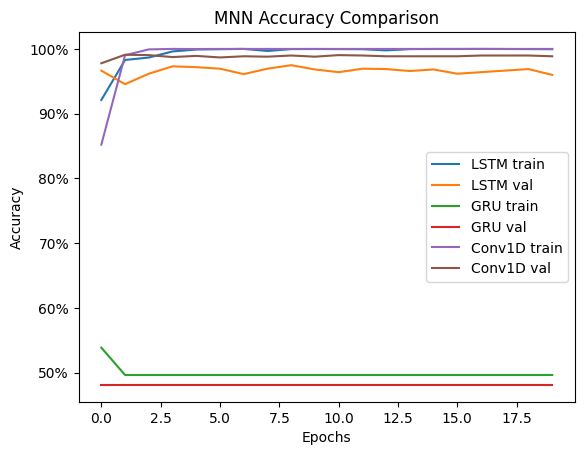

/var/folders/v0/7hny_wjs4tg70rryd7blqpd00000gn/T/ipykernel_94164/2508857317.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


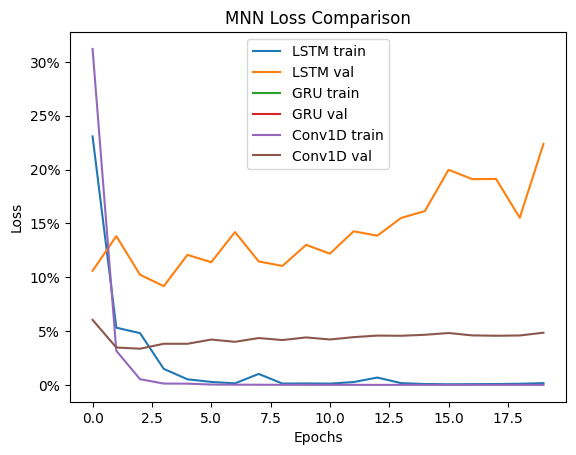

In [117]:
import matplotlib.pyplot as plt

def plot_history(histories, metrics=['accuracy', 'loss']):
    for metric in metrics:
        plt.figure()
        for model_name, history in histories.items():
            plt.plot(history.history[metric], label=f'{model_name} train')
            plt.plot(history.history[f'val_{metric}'], label=f'{model_name} val')
        plt.title(f'MNN {metric.capitalize()} Comparison')
        plt.xlabel('Epochs')
        #show the y labels as percentages
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.savefig(f'images/MNN_{metric}.png')
        plt.show()

plot_history({
    'LSTM': history_lstm,
    'GRU': history_gru,
    'Conv1D': history_conv1d
})


## Save the models for use by the web app

In [122]:
import joblib
# pickle the LSTM model
joblib.dump(lstm_model, "saved_models/lstm_model.pkl")

# pickle the GRU model
joblib.dump(gru_model, "saved_models/gru_model.pkl")

# pickle the Conv1D model
joblib.dump(conv1d_model, "saved_models/conv1d_model.pkl")

['conv1d_model.pkl']

# MNN Conclusions

On the initial training set of 2.5% of the FakeNews dataset, the Conv1D model won out over time, and was still improving its validation accuracy after 10 epochs, having achieved a 97% accuracy and declining loss of less than 9%.

The GRU model setup was likely flawed, as evidenced by its failure to improve over time or with a larger training set.  However, because Conv1d surpassed 99% validation accuracy, I decided not to correct these issues and to go ahead and use the optimized Conv1D model in the Legitimizer app.

A subsequent run of 10% of the FakeNews dataset over 20 epochs showed Conv1D maximizing its accuracy at an astounding 99% validation accuracy with mimimized loss after only three epochs.

Testing with real world, more recent news stories (using the Legitimizer app), showed more nuance and greater resiliency, where the single Logistic regression model was more rigid and binary in its classification, suggesting a decreasing applicability over time.

In [121]:
#rerun the conv1d model with only 3 epochs
history_conv1d = conv1d_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=64)


Epoch 1/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.7480 - loss: 0.5101 - val_accuracy: 0.9761 - val_loss: 0.0595
Epoch 2/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9909 - loss: 0.0349 - val_accuracy: 0.9892 - val_loss: 0.0303
Epoch 3/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9994 - loss: 0.0057 - val_accuracy: 0.9892 - val_loss: 0.0311
